In [1]:
import sys
import os
import numpy as np
import math
import scipy.optimize as opt

from astropy.io.fits import getdata
from astropy import wcs
from astropy.io import fits
from astropy import units as u
from astropy import constants as con
from astropy.coordinates import SkyCoord

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib


def Gaussian_2D(xdata_tuple, amp, x0, y0, sigma_x, sigma_y, theta, z0):
    (x, y) = xdata_tuple
    x0 = float(x0)
    y0 = float(y0)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = (np.sin(2*theta))/(4*sigma_x**2) - (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    z = z0 + amp*np.exp(-(a*(x-x0)**2+2*b*(x-x0)*(y-y0)+c*(y-y0)**2))
    return z.ravel()


In [2]:
def create_gaussian(track, rx):
    if track == 'track6':
        c1 = 79
        c2 = c1
    else:
        c1 = 39
        c2 = c1
    x = np.linspace(0, c1-1, c1)
    y = np.linspace(0, c2-1, c2)
    x, y = np.meshgrid(x, y)
    xdata = np.vstack((x.ravel(),y.ravel()))
    amp = (np.random.rand()*500+50)/1000
    x0 = np.random.rand()*(c1/9)+c1*4/9
    y0 = np.random.rand()*(c2/9)+c2*4/9
    
    if track == 'track4' and rx == 'rx345':
        # 2.355*sigma = FWHM, 1 pixel = 0.25 arcsec
        # fwhm = 2.0~3.2 arcsec
        # PA = 6.9~22.6 deg
        sigma_x = np.random.rand()*(1.2/0.25/2.355)+(2.0/0.25/2.355)
        sigma_y = np.random.rand()*(1.2/0.25/2.355)+(2.0/0.25/2.355)
        theta = np.random.rand()*15.7/180*math.pi+6.9/180*math.pi
        z0 = 0
    if track == 'track5' and rx == 'rx345':
        # 2.355*sigma = FWHM, 1 pixel = 0.25 arcsec
        # fwhm = 2.0~3.2 arcsec
        # PA = -8 ~ 7 deg
        sigma_x = np.random.rand()*(1.2/0.25/2.355)+(2.0/0.25/2.355)
        sigma_y = np.random.rand()*(1.2/0.25/2.355)+(2.0/0.25/2.355)
        theta = np.random.rand()*15.7/180*math.pi-8/180*math.pi
        z0 = 0
    if track == 'track6' and rx == 'rx345':
        # 2.355*sigma = FWHM, 1 pixel = 0.125 arcsec
        # fwhm = 1.5~2.5 arcsec
        # PA = -8 ~ 7 deg
        sigma_x = np.random.rand()*(1.0/0.125/2.355)+(1.5/0.125/2.355)
        sigma_y = np.random.rand()*(1.0/0.125/2.355)+(1.5/0.125/2.355)
        theta = np.random.rand()*15.7/180*math.pi-8/180*math.pi
        z0 = 0
    gaussian = Gaussian_2D(xdata, amp, x0, y0, sigma_x, sigma_y, theta, z0)
    data = gaussian.reshape(c1, c2)
    para = (amp, x0, y0, sigma_x, sigma_y, theta, z0)
    return data, para


In [3]:
def fitting_code(z):
    
    # Create x and y indices
    x = np.linspace(0, (z.shape[0]-1), (z.shape[0]))
    y = np.linspace(0, (z.shape[1]-1), (z.shape[1]))
    x, y = np.meshgrid(x, y)
    xdata = np.vstack((x.ravel(),y.ravel()))

    # initial guess
    max_x, max_y = np.unravel_index(np.argmax(z, axis=None), z.shape)
    max_pos = (max_x, max_y)
    max_flux = z[(max_x, max_y)]
    sigma_x = 10
    sigma_y = 10
    theta = 0
    z0 = 0
    p0= (max_flux, max_x, max_y, sigma_x, sigma_y, theta, z0)

    if (max_flux/rms > 3):
        
        # 2D Gaussiam fit
        try:
            popt, pcov = opt.curve_fit(Gaussian_2D, xdata, z.ravel(), p0=p0, maxfev=10000)
            peak_flux = popt[0]*1000
            cen = (popt[1], popt[2])
            fwhm_x = abs(popt[3])*math.sqrt(8*np.log(2))
            fwhm_y = abs(popt[4])*math.sqrt(8*np.log(2))
            major_axis = max(fwhm_x, fwhm_y)
            minor_axis = min(fwhm_x, fwhm_y)
            
            # fitted function
            z_fit = Gaussian_2D((x, y), *popt)
            integrated_flux = peak_flux*2*math.pi*(abs(popt[3]))*(abs(popt[4]))
#            integrated_flux = z_fit.sum()*1000
            pix_num = (math.pi*(major_axis/2)*(minor_axis/2)/(np.log(2)))
            total_flux = integrated_flux/pix_num
            SNR=(total_flux/rms)
            plt.imshow(z, origin='lower')
            plt.contour(x, y, z_fit.reshape(z.shape), 8, colors='w
            
#            print(np.c_[np.array(para), popt])
            perr = np.sqrt(np.diag(pcov))
            if perr[3] > 0.22 or perr[4] > 0.22:
                major_axis = 0.000000000000
                minor_axis = 0.000000000000
                total_flux = max_flux*1000
                popt = np.zeros(7)
                pcov = np.zeros([7, 7])
        except:
            major_axis = 0.000000000000
            minor_axis = 0.000000000000
            total_flux = max_flux*1000
            popt = np.zeros(7)
            pcov = np.zeros([7, 7])
    else:
        major_axis = 0.000000000000
        minor_axis = 0.000000000000
        total_flux = max_flux*1000
        popt = np.zeros(7)
        pcov = np.zeros([7, 7])
    
    
    return popt, pcov, max_flux*1000, total_flux


3 0.0 0.0 0.0
4 0.022707403914014223 0.20990247587565 0.1818754136841898
5 0.017036425897327224 0.1831889094717865 0.13895912285528383
6 0.01357968597349333 0.11332822938655446 0.15361618375542907
7 0.011276776435486403 0.12969975823665975 0.0958321874187144
8 0.009636711230197121 0.11122480265717884 0.08305849336138846
9 0.008410813790787305 0.0968894065183925 0.07330557594085603
10 0.007459577182086341 0.06560884293010881 0.08560375030350621
11 0.006701231897040321 0.0765287624026229 0.05937989703108172
12 0.006081913017084841 0.06912370486665123 0.05423309988973555
13 0.0055672892266345935 0.06297109826102688 0.04990846206618851
14 0.005132540994915069 0.057794403374076424 0.04622515558526648
15 0.0047605780427328595 0.053385007774020936 0.04304763006925252


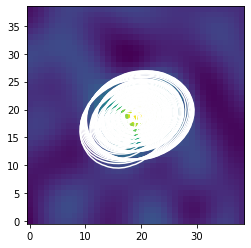

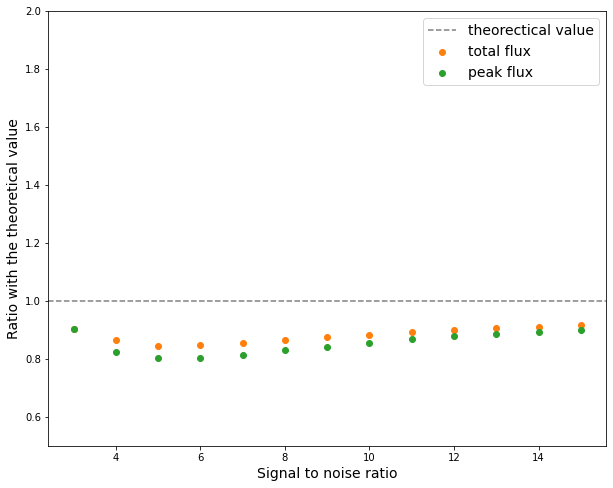

In [4]:
track = 'track5'
rx = 'rx345'

hdul = fits.open('CY_Tau.'+track+'.'+rx+'.lsb.clean.fits')
hdu = hdul[0]
xo = int(np.random.rand()*40)
yo = int(np.random.rand()*40)

ratios = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
data, para = create_gaussian(track, rx)
flux_m = []
flux_t = []
plt.imshow(data, origin='lower')
for r in ratios:
    flux = para[0]*1000
    rms = para[0]/r
    noise = hdu.data[0][0][xo:xo+data.shape[0], yo:yo+data.shape[1]]
#    plt.imshow(noise, origin='lower')
    z = data + noise*rms/noise.std() 
    if(r == 5):
        plt.imshow(z, origin='lower')
    popt, pcov, max_flux, total_flux = fitting_code(z)
    perr = np.sqrt(np.diag(pcov))
    # 0.22
    print(r, perr[0], perr[3], perr[4])
    flux_m.append(max_flux/flux)
    flux_t.append(total_flux/flux)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.scatter(ratios, flux_t, color='tab:orange')
ax.scatter(ratios, flux_m, color='tab:green')
ax.axhline(1, color='gray', linestyle='--')
plt.ylim([0.5, 2])
plt.ylabel('Ratio with the theoretical value', size=14)
plt.xlabel('Signal to noise ratio', size=14)
plt.legend(['theorectical value','total flux', 'peak flux'], prop={'size':14})

3 0.0 0.0 0.0
4 0.0 0.0 0.0
5 0.0 0.0 0.0
6 0.0 0.0 0.0
7 0.0 0.0 0.0
8 0.007741724645328076 0.08953935269856035 0.16746941304568427
9 0.007008808386146393 0.07809037491962621 0.13818252719629695
10 0.006347587240550123 0.06938416974773678 0.11860006205459296
11 0.0057826071787866725 0.10417457801379609 0.06247236008361412
12 0.005302307733927739 0.09300626562873662 0.056828289278793326
13 0.004891428341349928 0.08406653101800739 0.05213260646582772
14 0.0045377750467426965 0.07672258795371509 0.04815564098816757
15 0.00423043136052203 0.07057991493009667 0.04474551003332192


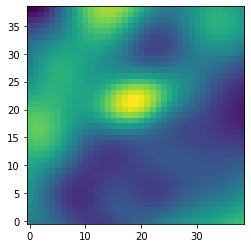

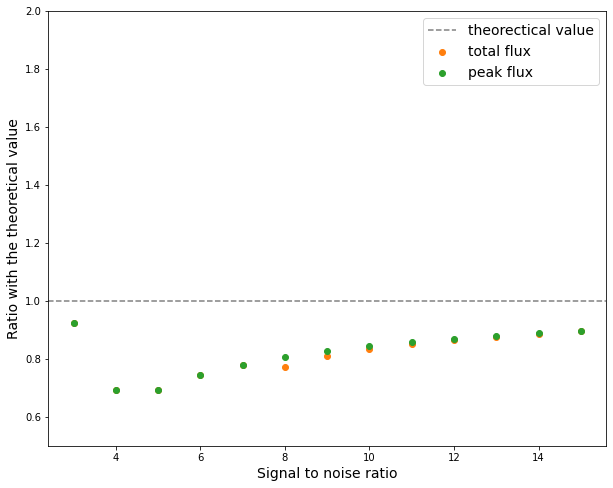

In [8]:
track = 'track4'
rx = 'rx345'

hdul = fits.open('CY_Tau.'+track+'.'+rx+'.lsb.clean.fits')
hdu = hdul[0]
xo = int(np.random.rand()*40)
yo = int(np.random.rand()*40)

ratios = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
data, para = create_gaussian(track, rx)
flux_m = []
flux_t = []
plt.imshow(data, origin='lower')
for r in ratios:
    flux = para[0]*1000
    rms = para[0]/r
    noise = hdu.data[0][0][xo:xo+data.shape[0], yo:yo+data.shape[1]]
#    plt.imshow(noise, origin='lower')
    z = data + noise*rms/noise.std() 
    if r == 5:
        plt.imshow(z, origin='lower')
    popt, pcov, max_flux, total_flux = fitting_code(z)
    perr = np.sqrt(np.diag(pcov))
    # 0.25
    print(r, perr[0], perr[3], perr[4])
    flux_m.append(max_flux/flux)
    flux_t.append(total_flux/flux)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.scatter(ratios, flux_t, color='tab:orange')
ax.scatter(ratios, flux_m, color='tab:green')
ax.axhline(1, color='gray', linestyle='--')
plt.ylim([0.5, 2])
plt.ylabel('Ratio with the theoretical value', size=14)
plt.xlabel('Signal to noise ratio', size=14)
plt.legend(['theorectical value','total flux', 'peak flux'], prop={'size':14})

3 0.0 0.0 0.0
4 0.0 0.0 0.0
5 0.0 0.0 0.0
6 0.007802909040788755 0.10584732148339132 0.1992642431208984
7 0.006741382199007177 0.09082009948563807 0.16696478910105136
8 0.005935458389943246 0.07952602794409584 0.1427115437768273
9 0.005301811185486746 0.07072420893211538 0.12411804646017964
10 0.004790854661757823 0.06365562379347248 0.10953927484736274
11 0.004369089507937994 0.05787273941053712 0.09787511670067868
12 0.004015131086554153 0.0530515983198867 0.0883659247443976
13 0.0037139258039820175 0.04896934025151682 0.08048464337853466
14 0.003454335550090304 0.045472207882240406 0.07385929702517004
15 0.0032285686770812567 0.04243777370806204 0.06821696195618938


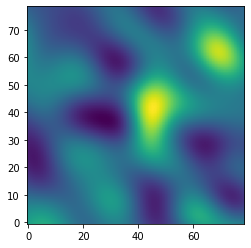

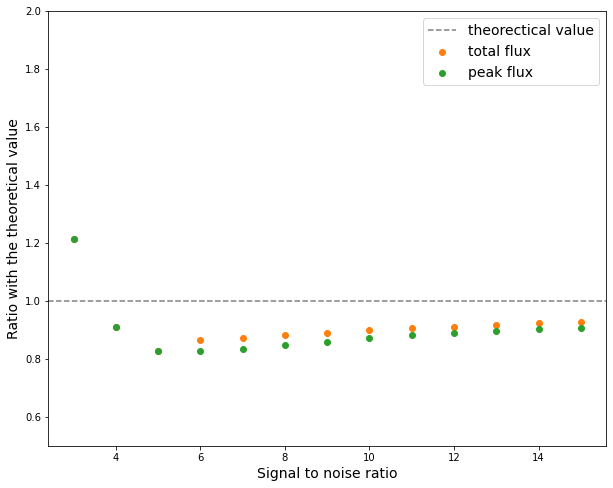

In [9]:
track = 'track6'
rx = 'rx345'

hdul = fits.open('CY_Tau.'+track+'.'+rx+'.lsb.clean.fits')
hdu = hdul[0]
xo = int(np.random.rand()*40)
yo = int(np.random.rand()*40)

ratios = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
data, para = create_gaussian(track, rx)
flux_m = []
flux_t = []
plt.imshow(data, origin='lower')
for r in ratios:
    flux = para[0]*1000
    rms = para[0]/r
    noise = hdu.data[0][0][xo:xo+data.shape[0], yo:yo+data.shape[1]]
#    plt.imshow(noise, origin='lower')
    z = data + noise*rms/noise.std() 
    if r == 5:
        plt.imshow(z, origin='lower')
    popt, pcov, max_flux, total_flux = fitting_code(z)
    perr = np.sqrt(np.diag(pcov))
    # 0.25
    print(r, perr[0], perr[3], perr[4])
    flux_m.append(max_flux/flux)
    flux_t.append(total_flux/flux)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.scatter(ratios, flux_t, color='tab:orange')
ax.scatter(ratios, flux_m, color='tab:green')
ax.axhline(1, color='gray', linestyle='--')
plt.ylim([0.5, 2])
plt.ylabel('Ratio with the theoretical value', size=14)
plt.xlabel('Signal to noise ratio', size=14)
plt.legend(['theorectical value','total flux', 'peak flux'], prop={'size':14})

In [763]:
track = 'track6'
rx = 'rx345'

def fitting_test(num):
    hdul = fits.open('CY_Tau.'+track+'.'+rx+'.lsb.clean.fits')
    hdu = hdul[0]
    xo = int(np.random.rand()*100)
    yo = int(np.random.rand()*100)
    
    ratios = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    data, para = create_gaussian(track, rx)
    flux_m = []
    flux_t = []
    
    for r in ratios:
        flux = para[0]*1000
        rms = para[0]/r
        noise = hdu.data[0][0][xo:xo+data.shape[0], yo:yo+data.shape[1]]
        z = data + noise*rms/noise.std() 
        plt.imshow(z, origin='lower')
        plt.savefig('gaussian_'+str(num)+'_'+str(r)+'.pdf', format='PDF', transparent=True)
        plt.close()
        prop, pcov, max_flux, total_flux = fitting_code(z)
        flux_m.append(max_flux/flux)
        flux_t.append(total_flux/flux)
    fig = plt.figure(figsize=(10, 8)).
    ax = fig.add_subplot(111)
    ax.scatter(ratios, flux_t, color='tab:orange')
    ax.scatter(ratios, flux_m, color='tab:green')
    ax.axhline(1, color='gray', linestyle='--')
    ax.set_ylim([0.5, 2])
    plt.ylabel('Ratio with the theoretical value', size=14)
    plt.xlabel('Signal to noise ratio', size=14)
    plt.legend(['theorectical value','total flux', 'peak flux'], prop={'size':14})
    plt.savefig('fitting_test'+str(num)+'.pdf', format='PDF', transparent=True)
    plt.close(fig)


In [764]:
times = 10
for i in range(times):
    fitting_test(i)
